<a href="https://colab.research.google.com/github/takotab/gas-predictor/blob/seq-fastai/notebooks/_v2_seq_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip3 install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip install git+https://github.com/fastai/fastai2

  Cloning https://github.com/fastai/fastai2 to /tmp/pip-req-build-4wndnwyg
  Running command git clone -q https://github.com/fastai/fastai2 /tmp/pip-req-build-4wndnwyg
  Created wheel for fastai2: filename=fastai2-0.0.1-cp37-none-any.whl size=159953 sha256=0a257361f3ffb471101ec245796bc515cb32894d32924e30602a50fba939c42c
  Stored in directory: /tmp/pip-ephem-wheel-cache-2b_texih/wheels/a1/59/9a/50335b36924b827e29d5f40b41fc3a008cc1f30dd80e560dfd
Successfully built fastai2


In [ ]:
import fastai2

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
import os
import sys
# sys.path.append('..')
# from pathlib import Path
import pandas as pd
import datetime as dt
import numpy as np
from tqdm import tqdm_notebook as tqdm
import seaborn as sns

/home/tako/devtools/fastai_dev/env/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/tako/devtools/fastai_dev/env/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
from fastai2.test import *
from fastai2.core import *
from fastai2.layers import *
from fastai2.data.all import *
from fastai2.optimizer import *
from fastai2.learner import *
from fastai2.metrics import *
from fastai2.text.core import *
from fastai2.text.data import *
from fastai2.text.models.core import *
from fastai2.text.models.awdlstm import *
from fastai2.callback.rnn import *
from fastai2.callback.all import *

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def plot_days(data, ax=None, left=None, right=None, figsize = None, title=None, spacing=.1,  **kwargs):
    from pandas import plotting
    figsize = ifnone(figsize,(5,5))
    if ax is None: _,ax = plt.subplots(figsize=figsize)           
    colors = getattr(getattr(plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=len(left)+len(right))
    for c in left+right:
        if c not in data:
            print(f'Warning{c} not in {data.columns}')
    # First axis
    ax = data.loc[:, left].plot(label=left, color=colors[:len(left)],ax = ax)
    ax.set_ylabel(ylabel=left)
    lines, labels = ax.get_legend_handles_labels()

    for n in range(len(right)):
        # Multiple y-axes 
        if right[n] in data.columns:
            
            ax_new = ax.twinx()
            ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
            data.loc[:, right[n]].plot(ax=ax_new, label=right[n], color=colors[len(left)+n % len(colors)],)
            ax_new.set_ylabel(ylabel=right[n])

            # Proper legend position
            line, label = ax_new.get_legend_handles_labels()
            lines += line
            labels += label

    ax.legend(lines, labels, loc=0)
    if title is not None: ax.set_title(title)
    return ax

In [ ]:
from copy import copy 
class BaseDays():
    def __init__(self,df, y_names, cat_var=None, con_var=None,cats={}):
        self.con_var, self.y_names = con_var, y_names                    
        self.df = df
        self.df.set_index('datetime',drop=False,inplace=True)  
        self.cols = ['datetime']+self.con_var
        self.cat_var = ifnone(cat_var,cats.keys())
        if cats == {}:
            self.cats = dict(self.df[self.cat_var].iloc[0,:])
        else:
            self.cats = cats
            for k,v in cats.items(): 
                self.df[k] = v
        for c in self.cols+self.y_names:
            if c not in self.df.columns:
                print(f'Warning {c} not in {self.df.columns} of {self.__class__}')
                
    def __repr__(self):
        return str(self.df)
    
    def copy(self):
        # https://stackoverflow.com/questions/17591104/in-pandas-can-i-deeply-copy-a-dataframe-including-its-index-and-column  
#         print('copy made ',self.__class__)
        return self.__class__(pd.DataFrame(self.df.values.copy(), self.df.index.copy(), self.df.columns.copy()),self.y_names.copy(),self.cat_var.copy(),self.con_var.copy())
    
    def repr(self):
        return {'y_names':self.y_names,'cat_var':self.cat_var,'con_var': self.con_var }
        
    @classmethod
    def from_intervals(cls,intervals,seq_len,y_names, cat_var, con_var):        
        return cls(_df, y_names, cat_var, con_var)
        

class Days(BaseDays):
   
    def show(self,plot=True,**kwargs):
        
        title= f"{self.cats}  from {str(min(self.df.loc[:,'datetime']))} to {str(max(self.df.loc[:,'datetime']))} #{self.df.shape[0]}"
        print(self.df.columns)
        if plot:
            plot_days(self.df,left=self.con_var,right=self.y_names+['pred'],title=title,**kwargs)
        else:
            return title+'\n'+str(self.df.head(1)   ) 
        
    @classmethod
    def from_ndays(cls, nday): 
        cats = {} if not hasattr(nday,'cats') else nday.cats
        return cls(nday.df, nday.y_names, nday.cat_var, nday.con_var, cats = cats)
        
class NotDays(BaseDays):    
    @classmethod
    def from_days(cls, day):   
        cats = {} if not hasattr(day,'cats') else day.cats 
        return cls(day.df, day.y_names, day.cat_var, day.con_var, cats = cats)

In [ ]:
d = Days(pd.DataFrame({'datetime':[pd.Timestamp('2019-01-01')+x*pd.Timedelta('1H') for x in range(24)],
                       'target':np.arange(24),'con':np.arange(24)-2,
                       'cat':[1]*24
                      }),['target'],['cat'],['con'])
_d = d.copy()
d.df['con'] += 4
test_ne(d.df['con'].values,_d.df['con'].values)
d_cat = Days(pd.DataFrame({'datetime':[pd.Timestamp('2019-01-01')+x*pd.Timedelta('1H') for x in range(24)],
                       'target':np.arange(24),'con':np.arange(24)-2,},),
                      ['target'],con_var=['con'], cats ={'cat':1}
                     )
test_eq(d_cat.cats,d_cat.cats)

CPU times: user 24.2 ms, sys: 5.85 ms, total: 30.1 ms
Wall time: 29.3 ms
Index(['datetime', 'loc', 'temp', 'pressure', 'humidity', 'city', 'target'], dtype='object')
Warningpred not in Index(['datetime', 'loc', 'temp', 'pressure', 'humidity', 'city', 'target'], dtype='object')


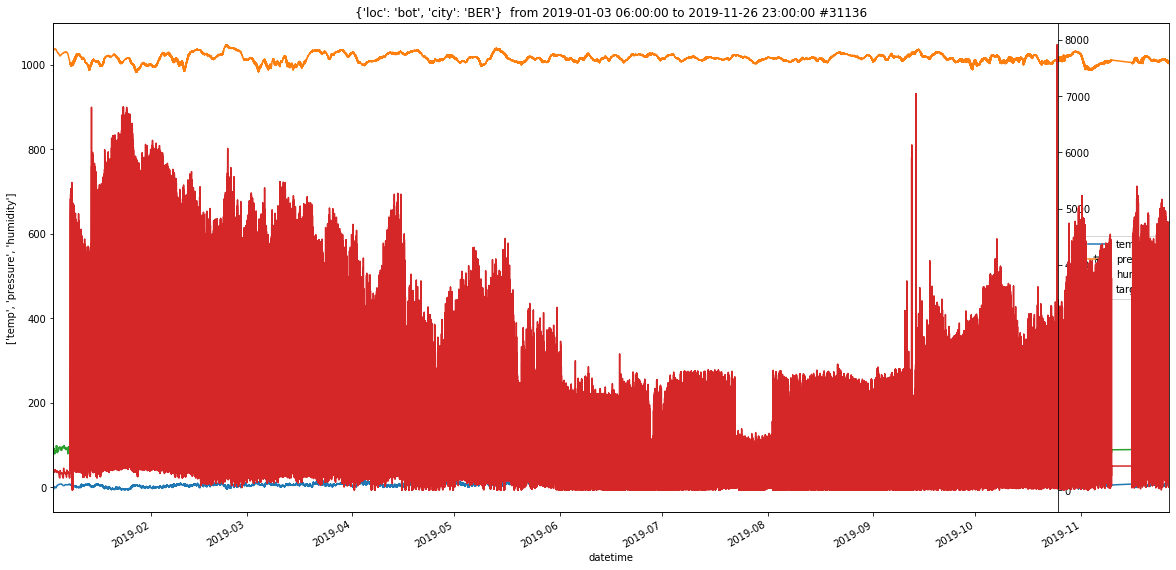

In [ ]:
def get_real_data(num, l=None, locations = 4, jumps = True, chance_of_jump = 0.9):
    df= pd.read_csv('/home/tako/devtools/vattenfall/gas-usage-prediction/gas_predictor/dataset/data_select_locs.csv',parse_dates=['datetime'])
    df['target'] = df['Wert']
    del df['Wert']
    return df
%time df = get_real_data(1,locations=1)
it = Days(df,['target'],['loc','city'],['temp','pressure','humidity'])
it.show(figsize=(20,10))

In [ ]:
df.head()

,datetime,loc,temp,pressure,humidity,city,target
datetime,,,,,,,
2019-02-14 08:00:00,2019-02-14 08:00:00,bot,5.8,1036.1,86.6,BER,5141.000
2019-02-26 12:00:00,2019-02-26 12:00:00,bot,6.5,1032.9,72.4,BER,4401.844
2019-02-26 13:00:00,2019-02-26 13:00:00,bot,9.8,1032.9,59.8,BER,4136.806
2019-03-05 07:00:00,2019-03-05 07:00:00,bot,6.2,998.7,73.5,BER,4906.360
2019-03-05 08:00:00,2019-03-05 08:00:00,bot,6.5,999.8,69.4,BER,4790.649


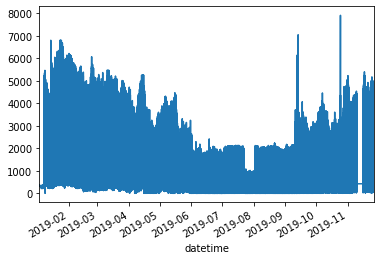

In [ ]:
it.df['target'].plot()

In [ ]:

_df = df[df['loc'] == 'bot']  
_df.head()

,datetime,loc,temp,pressure,humidity,city,target
datetime,,,,,,,
2019-02-14 08:00:00,2019-02-14 08:00:00,bot,5.8,1036.1,86.6,BER,5141.000
2019-02-26 12:00:00,2019-02-26 12:00:00,bot,6.5,1032.9,72.4,BER,4401.844
2019-02-26 13:00:00,2019-02-26 13:00:00,bot,9.8,1032.9,59.8,BER,4136.806
2019-03-05 07:00:00,2019-03-05 07:00:00,bot,6.2,998.7,73.5,BER,4906.360
2019-03-05 08:00:00,2019-03-05 08:00:00,bot,6.5,999.8,69.4,BER,4790.649


In [ ]:
from copy import copy
def to_elapsed(s):
    return s.astype(np.int64) // 10 ** 9

def remove_last(df,start, end, sz):
    old_start = copy(start)
    start = end - sz + pd.Timedelta(hours = 1)
    return df[start:end], old_start, start
    
def get_not_interval(df, interval, shift = 1):
    df["delta"] = abs(
        (to_elapsed(df["datetime"]) - to_elapsed(df["datetime"].shift(shift)))
    )
    #     df["delta"] = df['delta'].dt.seconds
    not_hour = df.index[df["delta"] != interval].tolist()
    del df["delta"]
    return not_hour
    

def make_interval(
    df: pd.DataFrame,
    sz='96H',
    interval=3600,
    max_splits=35,
    callback_error=None,
) -> pd.DataFrame:
    """Will check if `df.datetime` has interval of `interval` in seconds. 
    
    if not will make it happen and return a list where this is done.
    """
    df.index = df.datetime
    df = df.sort_index() 
    starts = get_not_interval(df, interval, 1)
    ends = get_not_interval(df, interval, -1)
    dfs = []
    for start, end in zip(starts,ends):  
        dt_range = pd.date_range(start,end,freq=sz)
        dfs += [df.loc[i:i+pd.Timedelta(sz),:] for i in dt_range[:-1] ]   
        if (end -dt_range[-1]).total_seconds()/3600 >3:
            dfs += [df.loc[dt_range[-1]:end,:]]
#         print([(i,d.shape) for i,d in enumerate(dfs) if d.shape[0]!=73])
    return dfs

dfs = []
for l in set(df['loc']):  
    _df = df[df['loc'] == l]  
    dfs += L(make_interval(_df)).map(lambda x: Days(x, ['target'], ['city','loc'], ['temp','pressure','humidity']))
    break
lengths =pd.DataFrame({'rows':[dfs[i].df.shape[0] for i in range(len(dfs))]})


In [ ]:
[(dfs[i].df, i) for i in range(len(dfs)) if dfs[i].df.isnull().sum().sum()>0]

[]

In [ ]:
pd.value_counts(lengths['rows'])

97    71
93     1
72     1
44     1
Name: rows, dtype: int64

In [ ]:
df = get_real_data(1)
items = []
for l in set(df['loc']):  
    _df = df[df['loc'] == l]  
    items += L(make_interval(_df)).map(lambda x: Days(x, ['target'], ['city','loc'], ['temp','pressure','humidity']))
    

In [ ]:
print('\n'.join([d.show(plot=False) for d in items[[0,-1]][::-1]]))

Index(['datetime', 'loc', 'temp', 'pressure', 'humidity', 'city', 'target'], dtype='object')
Index(['datetime', 'loc', 'temp', 'pressure', 'humidity', 'city', 'target'], dtype='object')
{'city': 'DRE', 'loc': 'frd'}  from 2019-11-24 00:00:00 to 2019-11-26 23:00:00 #72
             datetime  loc  temp  pressure  humidity city  target
datetime                                                         
2019-11-24 2019-11-24  frd   6.5    1006.3      79.9  DRE  33.311
{'city': 'BER', 'loc': 'nde'}  from 2019-02-01 06:00:00 to 2019-02-05 06:00:00 #97
                               datetime  loc  temp  pressure  humidity city  \
datetime                                                                      
2019-02-01 06:00:00 2019-02-01 06:00:00  nde  -2.2     997.9      89.5  BER   

                      target  
datetime                      
2019-02-01 06:00:00  563.512  


In [ ]:
def split_idxs(items):
    total = 0
    train_idx, valid_idx, test_idx = [], [], []
    train_idx_s, valid_idx_s, test_idx_s = 0,0,0
    for idx, it in enumerate(items):
        
        ts = it.df['datetime'].iloc[0]
        total += _df.shape[0]
        if  ts.month == 2       :
            if ts.minute == 0:
                test_idx.append(idx)
                test_idx_s += _df.shape[0]

        elif ts.month == 9 or ts.month == 10:
            if ts.minute == 0:
                valid_idx.append(idx)
                valid_idx_s += _df.shape[0]
        else:
            train_idx.append(idx)
            train_idx_s +=_df.shape[0]

    if len(valid_idx) == 0 and len(train_idx):
        valid_idx.append(train_idx.pop(-1))
    if len(test_idx) == 0 and len(train_idx):
        test_idx.append(train_idx.pop(-1))
    print()
    print("Test set length\t\t", test_idx_s / total, test_idx_s)
    print("Validation set length\t", valid_idx_s / total,valid_idx_s)
    print("Train set length\t", train_idx_s / total, train_idx_s)
    print(total, test_idx_s)
    
    return [train_idx, valid_idx, test_idx]

splits = split_idxs(items)


Test set length		 0.08484848484848485 50400
Validation set length	 0.22727272727272727 135000
Train set length	 0.6878787878787879 408600
594000 50400


In [ ]:
def _to_elapsed(o:int):
    return o // 10 ** 9
def _to_dt(o):
    return o*(10**9)
pd.Timestamp(_to_dt(_to_elapsed(pd.Timestamp('2019-01-01').value)))

Timestamp('2019-01-01 00:00:00')

In [ ]:
class Add_features(Transform):    
        
    def encodes(self, o:Days): 
        a = o.copy()  
        a.df.loc[:,'hour'] =pd.Series(a.df['datetime'].dt.hour,
                                      index=a.df.index
                                     )
        a.con_var += ['hour']        
        return NotDays.from_days(a)
    
    def decodes(self, o:NotDays): 
        a = o.copy() 
        a.con_var.remove('hour')
        a.cols.remove('hour')
        del a.df['hour']
        return Days.from_ndays(a)

In [ ]:
_df = get_real_data(1,locations=1)
it = Days(_df, ['target'],['loc','city'],['temp','pressure','humidity'])
add_f = Add_features()
_it = add_f(it) 
test_eq(_it.df.hour, _it.df.datetime.dt.hour)
test_eq(_it.con_var,['temp','pressure','humidity','hour'] )
assert 'hour' in _it.cols

d_it = add_f.decodes(it)
test_eq(d_it.cols,['datetime','temp','pressure','humidity'])
test_eq(d_it.con_var,['temp','pressure','humidity'])

test_eq(it.df, add_f.decode(add_f(it)).df)
test_eq(Days, type(add_f.decode(add_f(it))))

In [ ]:
class Change_dt(Transform):
    def __init__(self, start=None, col='datetime'):
        self.start = ifnone(start, _to_elapsed(pd.Timestamp('2019-01-01').value))
        self.col = col
        
    def encodes(self, o:NotDays): 
        a = o.copy()        
        a.df[self.col] = _to_elapsed(a.df[self.col].astype(int)) - self.start
        return a
    
    def decodes(self, o:NotDays): 
        o.df[self.col] = pd.to_datetime(_to_dt(o.df[self.col] + self.start))
        o.df.index = o.df[self.col]
        print(o.cats)
        return o

In [ ]:
_df = get_real_data(1,locations=1)
it = NotDays(_df, ['target'],['loc','city'],['temp','pressure','humidity'])
Dt = Change_dt()
_it = Dt(it) 
test_eq(type(_it),NotDays)
_ = Dt.decodes(_it)
test_eq(it.df, Dt.decode(Dt(it)).df)

{'loc': 'bot', 'city': 'BER'}
{'loc': 'bot', 'city': 'BER'}


In [ ]:
class DaysTuple(Tuple):
    def show(self, ctx=None, **kwargs): 
        tensors, catagories = self
        return show_image(torch.cat([img1,img2], dim=2), title=same_breed, ctx=ctx)

In [ ]:
class TensorSequence(TensorBase):pass
# class TensorSequenceHint(TensorBase):pass

class Numericalize(Transform):
    "Reversible transform of tokenized cat_var to numericalized ids"
    
    def setup(self, dsrc):
        if dsrc is None: return
        self.item = dsrc[0]
        self.vocab,self.o2i = {},{}
        for cat in self.item.cats.keys():
            count = L()            
            for i in [o.cats[cat] for o in dsrc]:
                count.append(i)
            self.o2i[cat] = {k:int(i) for i,k in enumerate(count.unique() + L(0))}            
            self.vocab[cat] = {v:k for k,v in self.o2i[cat].items()}

    def encodes(self, inp:NotDays):
        o = inp.copy()
        cats = L()
        for c in self.item.cats:
            cats.append(self.o2i[c][o.cats[c]])
            
        for y_name in self.item.y_names:
            temp = o.df[y_name].iloc[[i%24 for i in range(o.df.shape[0])]].values.flatten()
            o.df.drop(y_name, axis=1,inplace=True)
            o.df = o.df.assign(**{n:0 for n in y_name})
            o.df[y_name] = pd.Series(temp, index=o.df.index)
            o.df.loc[:,y_name]
        
        res = o.df.loc[:,self.item.cols+self.item.y_names].fillna(0).values
        return DaysTuple(TensorSequence(res),Tensor(cats).long())
    
    def decodes(self, inpt:DaysTuple):    
        o = pd.DataFrame(inpt[0].numpy(),columns = self.item.cols+self.item.y_names)
        cats = {}
        for i,c in enumerate(self.item.cat_var):
            cats[c] = self.vocab[c][int(inpt[1][i])]
        return NotDays(o,**self.item.repr(),cats=cats)
    
    def get_vocab_sz(self):
        return [len(self.vocab[v]) for v in self.item.cat_var]
    

In [ ]:
df = get_real_data(50,locations=4,l=73,jumps=False)
items = []
for l in set(df['loc']):  
    _df = df[df['loc'] == l]  
    items += L(make_interval(_df)).map(lambda x: Days(x, ['target'], ['city','loc'], ['temp','pressure','humidity']))    
num = Numericalize()
num.setup(items)
test_eq(len(num.vocab['loc']), len(set(df['loc']))+1)
test_eq(len(num.vocab['city']), len(set(df['city']))+1)
test_eq(num.get_vocab_sz(),(len(set(df['city']))+1, len(set(df['loc']))+1))

numericalize {'city': 'BER', 'loc': 'nde'}
{'city': 'BER', 'loc': 'nde'}
numericalize {'city': 0, 'loc': 0}
{'city': 0, 'loc': 0}


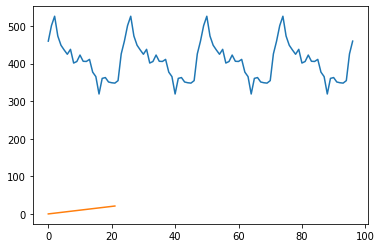

In [ ]:
its = [NotDays.from_days(items[10])]
_df = pd.DataFrame({n:np.arange(22) for n in ['target','city','loc', 'temp','pressure','humidity','datetime']})
its += [NotDays(_df, ['target'], ['city','loc'], ['temp','pressure','humidity'])]
Dt = Change_dt()
for it in its:
    _it = Dt(it)
    _it = num(_it)
    plt.plot((_it[0][:,-1]).numpy())
    test_eq(torch.isnan(_it[0]).sum(),0)
    test_eq(type(_it), DaysTuple)
    d = Dt.decodes(num.decodes(_it ))
    test_eq(type(d), NotDays)
    test_eq(d.df[it.cols],it.df[it.cols])
    test_eq(d.cats,it.cats)

In [ ]:
class TensorSequenceY(TensorBase):pass

class TargetSequence(pd.DataFrame):
    def show(self, ctx=None,ax=None,figsize=None, **kwargs): 
        y = self
        figsize = ifnone(figsize,(5,5))
        if ax is None: _,ax = plt.subplots(figsize=figsize)
        ax.plot(y)
        return ax
        
class Label(Transform):    
    def setup(self, dsrc):
        if dsrc is None: return
        self.item = dsrc[0]
        
    def encodes(self, o:Days): 
        return TensorSequenceY(tensor(o.df[self.item.y_names].copy().values))
    
    def decodes(self, o:TensorSequenceY):         
        o = pd.DataFrame(o.numpy(),columns = self.item.y_names )
        return TargetSequence(o)
    

In [ ]:
df = get_real_data(1,)
items = []
for l in set(df['loc']):  
    _df = df[df['loc'] == l]  
    items += L(make_interval(_df)).map(lambda x: Days(x, ['target'], ['city','loc'], ['temp','pressure','humidity']))    

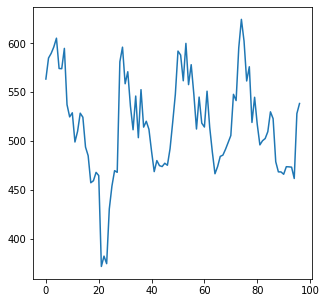

In [ ]:
lab = Label()
lab.setup(items[:10])
test_eq(lab(items[0]).shape,(97,1))
test_eq(lab.decodes(lab(items[0])).shape, (97, 1))
lab.decodes(lab(items[0])).show()

In [ ]:
class SeqLen(Transform):
    def __init__(self,len=73):
        self.len = len
        
    def encodes(self, o:TensorBase):   
        a = torch.zeros(self.len,o.shape[1])
        _len = min([self.len,o.shape[0]])
        a[:_len,:] = o[:_len,:]
        return a
    
    def encodes(self, inpt:DaysTuple):   
        o, cats = inpt
        a = self.encodes(o)
        return DaysTuple(a, cats)
    
    
    def decodes(self, o):
        return o
    

In [ ]:
seqlen = SeqLen(73)
test_eq(seqlen(TensorSequenceY(np.random.rand(50,3))).shape,(73,3))
test_eq(seqlen(TensorSequenceY(np.random.rand(50,8))).shape,(73,8))

In [ ]:
del seqlen
seqlen = SeqLen(10)
test_eq(seqlen(TensorSequenceY(np.random.rand(50,3))).shape,(10,3))

In [ ]:
d = DaysTuple(TensorBase(np.random.rand(50,3)),{"a":1})
test_eq(seqlen(d)[0].shape,(10,3))
test_eq(seqlen(d)[1],{"a":1})

In [ ]:
class Normalize(Transform):   
    def __init__(self, norm_cols= None):
        self.norm_cols = norm_cols
        
    def setup(self, dsrc):
        if dsrc is None: return
        print(dsrc[0][0].shape)
        if self.norm_cols == None:
            self.norm_cols = range(dsrc[0][0].shape[-1])
        its = torch.cat([o[0][None,:,self.norm_cols] for o in dsrc])
        self.m, self.s = Tensor([0]*dsrc[0][0].shape[-1]),Tensor([1]*dsrc[0][0].shape[-1])
        self.m[self.norm_cols],self.s[self.norm_cols] = its.mean((0,1)),its.std((0,1))+1e-5
        
    def encodes(self, inpt):
        o,cats = inpt
        o = (o-self.m)/self.s
        return DaysTuple(o,cats)
        
    
    def decodes(self, inpt):   
        o,cats = inpt      
        o= (o*self.s)+self.m
        return DaysTuple(o,cats)
    

In [ ]:
a = np.array([[1+np.arange(7)]*73]*100)*(1+.3*np.random.randn(100,73,7))
# a[:,:,6] = 3.14
print(a.shape)
b = Tensor(a)
(b.mean((0,1)),b.std((0,1)))

(100, 73, 7)


(tensor([0.9987, 1.9984, 3.0172, 3.9998, 5.0094, 6.0252, 6.9879]),
 tensor([0.3006, 0.5976, 0.8958, 1.2004, 1.4907, 1.8038, 2.0998]))

In [ ]:
norm = Normalize(range(6))
its = Tensor()
norm.setup([(Tensor(a[i]),{}) for i in range(a.shape[0])])
print(norm.m,norm.s)
test_close(norm.m, Tensor([1,2,3,4,5,6,0]),0.1)
test_close(norm.s,Tensor([.3,.6,.9,1.2,1.5,1.8,1]),0.1)

torch.Size([73, 7])
tensor([0.9987, 1.9984, 3.0172, 3.9998, 5.0094, 6.0252, 0.0000]) tensor([0.3006, 0.5976, 0.8958, 1.2004, 1.4907, 1.8038, 1.0000])


In [ ]:
res = norm((Tensor(a),{'foo':'bar'}))
test_close(res[0].mean((0,1)),Tensor([0]*6 + [7]),0.1)
test_close(res[0].std((0,1)),Tensor([1]*6+[2.1]),0.1)

In [ ]:
a_res = norm.decodes(res)[0]
test_close(a_res.mean((0,1)), Tensor([1,2,3,4,5,6,7]),0.1)
test_close(a_res.std((0,1)), Tensor([.3,.6,.9,1.2,1.5,1.8,2.1]),0.1)

In [ ]:
df = get_real_data(1)
set(df['loc']),set(df['city'])

({'bot', 'bra', 'frd', 'gln1', 'nde'}, {'BER', 'DRE', 'HAM'})

In [ ]:
items = []
for l in set(df['loc']):  
    _df = df[df['loc'] == l]  
    items += L(make_interval(_df)).map(lambda x: Days(x, ['target'], ['city','loc'], ['temp','pressure','humidity']))

In [ ]:
items[0].df.head()
# {i: items[i].df.shape  for i in range(len(items)) if  set(items[i].df['loc']) == {np.nan}}

,datetime,loc,temp,pressure,humidity,city,target
datetime,,,,,,,
2019-02-01 06:00:00,2019-02-01 06:00:00,nde,-2.2,997.9,89.5,BER,563.512
2019-02-01 07:00:00,2019-02-01 07:00:00,nde,-2.8,997.9,91.6,BER,584.967
2019-02-01 08:00:00,2019-02-01 08:00:00,nde,-2.6,997.5,90.2,BER,589.755
2019-02-01 09:00:00,2019-02-01 09:00:00,nde,-1.6,997.1,83.8,BER,596.308
2019-02-01 10:00:00,2019-02-01 10:00:00,nde,-0.4,996.8,77.1,BER,605.265


In [ ]:
splits = split_idxs(items)


Test set length		 0.08484848484848485 50400
Validation set length	 0.22727272727272727 135000
Train set length	 0.6878787878787879 408600
594000 50400


In [ ]:
# import warnings
# warnings.filterwarnings('ignore')


In [ ]:
bs,sl = 16,97
dsrc = DataSource(items.copy(), [[Add_features(), Change_dt(), Numericalize(), SeqLen(sl), Normalize(range(5))],
                          [Label(), SeqLen(sl)]
                         ],
                  splits=splits)

torch.Size([97, 6])


In [ ]:
dbch = dsrc.databunch(bs=bs, after_batch=[Cuda])
(dbch.one_batch()[0][0].shape, dbch.one_batch()[0][1].shape,dbch.one_batch()[1].shape)

(torch.Size([16, 97, 6]), torch.Size([16, 2]), torch.Size([16, 97, 1]))

numericalize {'city': 'BER', 'loc': 'bot'}
{'city': 'BER', 'loc': 'bot'}
Index(['datetime', 'temp', 'pressure', 'humidity', 'target', 'city', 'loc'], dtype='object')
Warningpred not in Index(['datetime', 'temp', 'pressure', 'humidity', 'target', 'city', 'loc'], dtype='object')


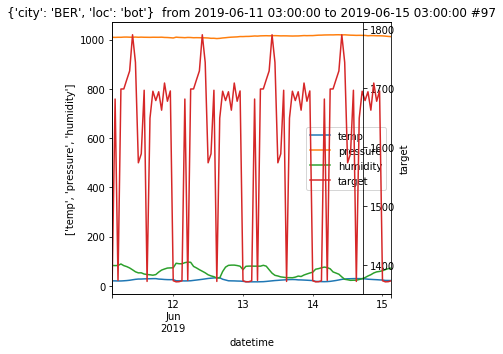

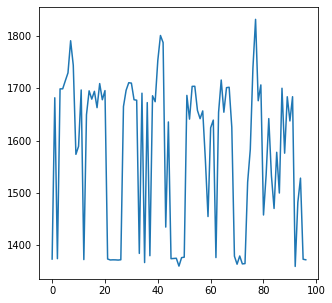

In [ ]:
dbch.show_batch(max_n=1)

In [ ]:
def emb_sz_rule(n_cat): 
    "Rule of thumb to pick embedding size corresponding to `n_cat`"
    return min(600, round(1.6 * n_cat**0.56))

def _one_emb_sz(classes, n, sz_dict=None):
    "Pick an embedding size for `n` depending on `classes` if not given in `sz_dict`."
    sz_dict = ifnone(sz_dict, {})
    n_cat = len(classes[n])
    sz = sz_dict.get(n, int(emb_sz_rule(n_cat)))  # rule of thumb
    return n_cat,sz

def get_emb_sz(to, sz_dict=None):
    "Get default embedding size from `TabularPreprocessor` `proc` or the ones in `sz_dict`"
    return [_one_emb_sz(to.procs.classes, n, sz_dict) for n in to.cat_names]

In [ ]:
print(dbch.tfms[0][2].vocab)
emb_sz = [(n,emb_sz_rule(n)) for n in dbch.tfms[0][2].get_vocab_sz()]
print(emb_sz)

{'city': {0: 'BER', 1: 'HAM', 2: 'DRE', 3: 0}, 'loc': {0: 'nde', 1: 'gln1', 2: 'bra', 3: 'bot', 4: 'frd', 5: 0}}
[(4, 3), (6, 4)]


In [ ]:
class LSTM(Module):
    initrange=0.1

    def __init__(self, emb_szs, n_in, n_hid, n_layers,n_out):
        store_attr(self, 'emb_szs,n_hid,n_layers')
        # not going to use embeddings for now
        self.emb = nn.ModuleList([nn.Embedding(emb_sz[0], emb_sz[1]) for emb_sz in emb_szs ])
        n_emb = sum(e.embedding_dim for e in self.emb)
        self.bn = nn.BatchNorm1d(n_in)
        self.bn.bias.data.fill_(1e-3)
        self.bn.weight.data.fill_(1)
        self.bn2 = nn.BatchNorm1d(n_hid)
        self.w_rnn = nn.Parameter(Tensor([0]*n_hid))
        self.w_in = nn.Parameter(Tensor([1]*(n_in+n_emb)))         
        self.rnn = nn.LSTM(n_in + n_emb, n_hid, n_layers-1, batch_first=True)         
        self.last_layer = nn.Conv1d(n_hid + n_emb + n_in, n_out, 1,)   
#         self.last_layer = nn.Conv1d(n_hid , n_out, 1,)
        self.act = nn.ReLU()
        self.out=[]
       
    def track_out(self,x):
        o = x.cpu().detach().numpy()
        self.out.append({'mean':np.float(o.mean()),'std':np.float(o.std())})
                
    def forward(self, x):
        con, cats = x
        cats = [e(cats[:,i]) for i,e in enumerate(self.emb)]
        cats = torch.cat(cats, 1)[:,:,None] 
        cats = torch.ones(con.shape[0],cats.shape[1],con.shape[1]).to(device)*cats
        norm_con = self.bn(con.transpose(1,2)).transpose(1,2)
        comb = torch.cat([norm_con, cats.transpose(1,2)], 2)
        raw_output = self.rnn(comb)[0].transpose(1,2)
        raw_output = self.bn2(raw_output)
        self.track_out(raw_output)
#         raw_output = torch.cat([self.w_rnn[None,:,None]*raw_output, self.w_in[None,:,None]* comb.transpose(1,2)], 1)        
        raw_output = torch.cat([self.w_rnn[None,:,None]*raw_output, self.w_in[None,:,None]* comb.transpose(1,2)], 1)        
        o = self.last_layer(raw_output).transpose(1,2)
        return self.act(con[:,:,-1][:,:,None] + o)


mdl = LSTM(emb_sz, 6, 8, 2, 1).to(device)
b = dbch.one_batch()
out = mdl(b[0])
print(out.shape)


torch.Size([16, 97, 1])


In [ ]:
[o for o in mdl.out]

[{'mean': 0.0, 'std': 0.9999099373817444}]

In [ ]:
learn = Learner(dbch, LSTM(emb_sz, 6, 64, 3, 1), loss_func=MSELossFlat(), opt_func=RAdam, metrics=[mae])

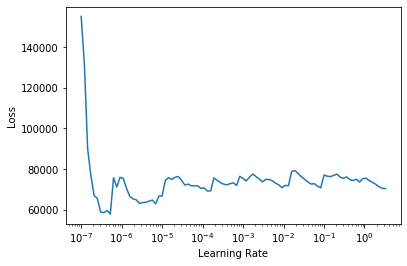

In [ ]:
learn.lr_find()

In [ ]:
learn.out = []

In [ ]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,mae,time
0,72385.625000,100815.078125,131.261490,00:02
1,73797.195312,100813.929688,131.260788,00:02
2,74914.156250,100806.703125,131.272598,00:02
3,74150.421875,100829.179688,131.416214,00:02
4,73657.835938,100493.367188,131.427612,00:02
5,72895.062500,99893.179688,131.089706,00:02
6,73539.625000,100293.351562,131.582611,00:02
7,72613.609375,99659.851562,131.620789,00:02
8,72094.625000,99325.257812,131.638977,00:02
9,71810.070312,99129.148438,131.516922,00:02


In [ ]:
learn.validate()

(#2) [88869.4296875,107.71693420410156]

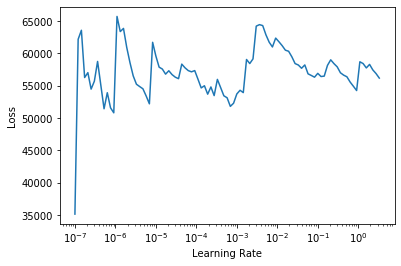

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

KeyboardInterrupt: 

In [ ]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,mae,time
0,2490.026123,2387.066406,43.486980,00:01
1,2483.208740,2434.425781,44.153141,00:01
2,2448.245850,2447.329102,44.402328,00:01
3,2435.943604,2447.833496,44.481369,00:01
4,2488.174316,2428.796631,44.306824,00:01
5,2476.267090,2411.517578,44.164745,00:02
6,2459.271240,2412.299072,44.194176,00:01
7,2442.338135,2400.774170,44.058189,00:01
8,2446.590332,2405.853271,44.127064,00:01
9,2440.286133,2407.482666,44.149010,00:01


In [ ]:
df = pd.DataFrame(learn.model.out)

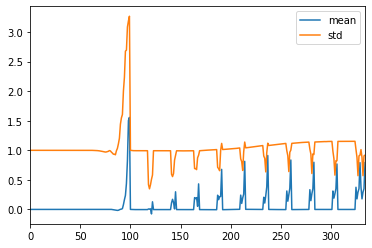

In [ ]:
df.plot()

Index(['datetime', 'temp', 'pressure', 'humidity', 'target'], dtype='object')
Warningpred not in Index(['datetime', 'temp', 'pressure', 'humidity', 'target'], dtype='object')


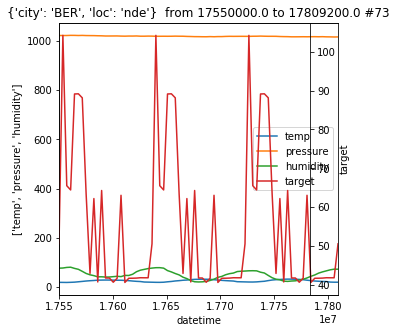

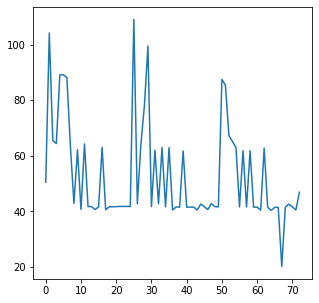

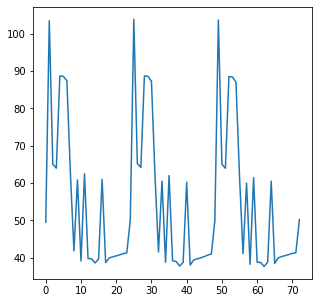

In [ ]:
learn.show_results(max_n=1)

Warning target not in Index(['datetime', 'temp', 'pressure', 'humidity', 'hour'], dtype='object')
Warning target not in Index(['datetime', 'temp', 'pressure', 'humidity', 'hour'], dtype='object')
Warning target not in Index(['datetime', 'temp', 'pressure', 'humidity', 'hour'], dtype='object')
Warning target not in Index(['datetime', 'temp', 'pressure', 'humidity', 'hour'], dtype='object')
Index(['datetime', 'temp', 'pressure', 'humidity', 'hour'], dtype='object')
Warningtarget not in Index(['datetime', 'temp', 'pressure', 'humidity', 'hour'], dtype='object')
Warningpred not in Index(['datetime', 'temp', 'pressure', 'humidity', 'hour'], dtype='object')
Index(['datetime', 'temp', 'pressure', 'humidity', 'hour'], dtype='object')
Warningtarget not in Index(['datetime', 'temp', 'pressure', 'humidity', 'hour'], dtype='object')
Warningpred not in Index(['datetime', 'temp', 'pressure', 'humidity', 'hour'], dtype='object')


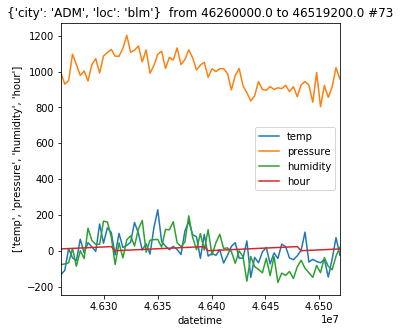

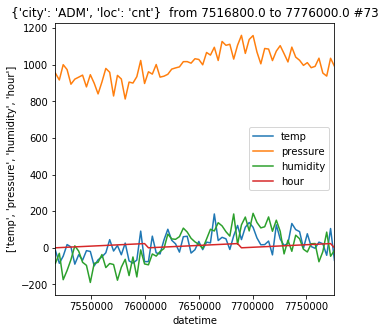

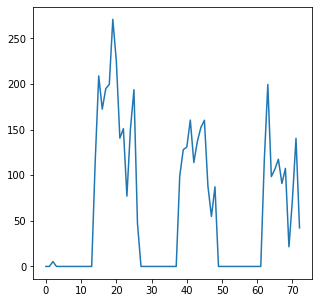

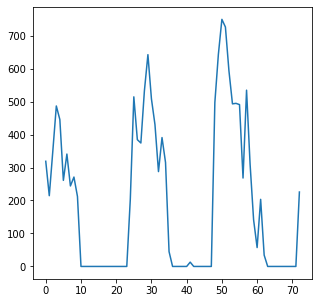

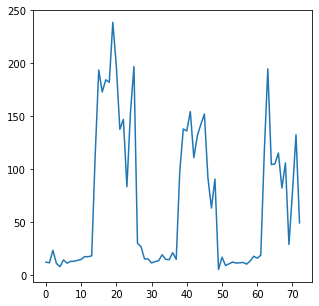

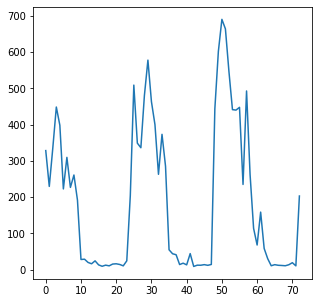

In [ ]:
learn.show_results(max_n=2)

Warning target not in Index(['datetime', 'temp', 'pressure', 'humidity', 'hour'], dtype='object')
Warning target not in Index(['datetime', 'temp', 'pressure', 'humidity', 'hour'], dtype='object')
Warning target not in Index(['datetime', 'temp', 'pressure', 'humidity', 'hour'], dtype='object')
Warning target not in Index(['datetime', 'temp', 'pressure', 'humidity', 'hour'], dtype='object')
Warning target not in Index(['datetime', 'temp', 'pressure', 'humidity', 'hour'], dtype='object')
Warning target not in Index(['datetime', 'temp', 'pressure', 'humidity', 'hour'], dtype='object')
Index(['datetime', 'temp', 'pressure', 'humidity', 'hour'], dtype='object')
Warningtarget not in Index(['datetime', 'temp', 'pressure', 'humidity', 'hour'], dtype='object')
Warningpred not in Index(['datetime', 'temp', 'pressure', 'humidity', 'hour'], dtype='object')
Index(['datetime', 'temp', 'pressure', 'humidity', 'hour'], dtype='object')
Warningtarget not in Index(['datetime', 'temp', 'pressure', 'humidit

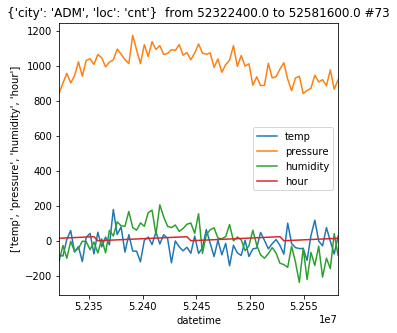

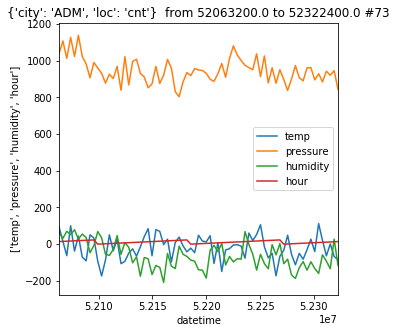

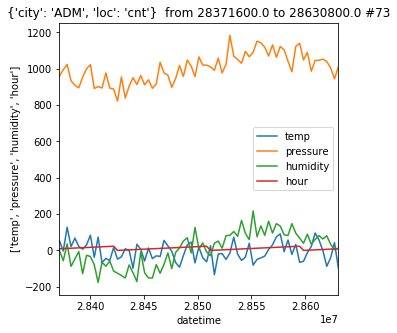

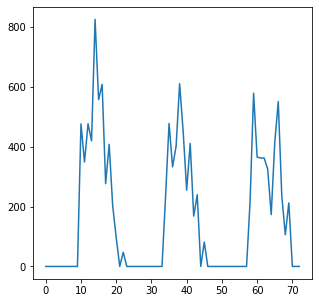

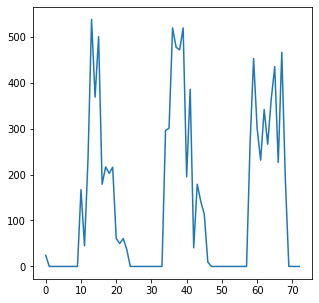

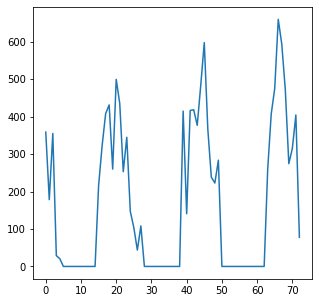

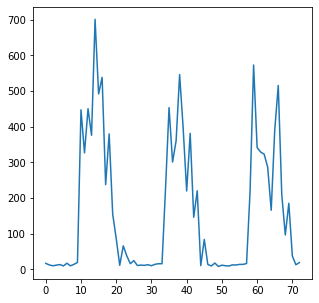

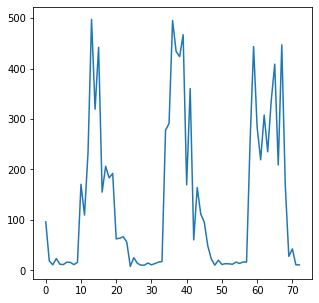

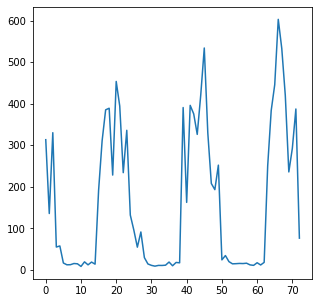

In [ ]:
learn.show_results(max_n=3)